# Music Instrument Classification

# 1. Data Processing

In [55]:
# Imports

#General
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt

# System
import os, fnmatch

# Random Seed
from numpy.random import seed
seed(1)

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC

# Audio
import librosa.display, librosa

# Configurations
path='./data/instruments/'
nClasses = 6

### Get filenames

In [20]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))
#print("files=" + str(files))

found 600 audio files in ./data/instruments/


### Prepare labels from filenames

In [21]:
# Get Labels
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

print("labels.len=" + str(len(labels)))
print("color_list.len=" + str(len(color_list)))
#print("labels=" + str(labels))
#print("color_list=" + str(color_list))

labels.len=600
color_list.len=600


### Encode Labels

In [30]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)
print("classes_num.shape=" + str(classes_num.shape))
#print("classes_num=" + str(classes_num))

6 classes: cello, flute, oboe, sax, trumpet, viola
classes_num.shape=(600,)


## Parameters for MFCC

In [22]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

# 2. Features Vectors' Calculating

## Function to Calculate Audio Features: MFCC

In [23]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [24]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    #print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        #print("feat.shape=" + str(feat.shape))
        #feat.shape=(13,)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))
#print("feature_vectors.type=" + str(type(feature_vectors)))
#print("feature_vectors[0].type=" + str(type(feature_vectors[0])))

Calculated 600 feature vectors


## Standardization: Zero-Mean and Unit-Variance

In [34]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (600, 13)


## Training Data and Test Data spliting

In [35]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [36]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


# 3. Multiclass SVM Classification

In [40]:
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1) 
svclassifier.fit(train_set, train_classes);

In [41]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = svclassifier.predict(test_set)

In [46]:
#print("predicted_labels=" + str(predicted_labels))
test_accuracy = svclassifier.score(test_set, test_classes)
print("test_accuracy=" + str(test_accuracy))

test_accuracy=0.9866666666666667


In [65]:
def plot_predicted_classes(Xtest,ytest,ypred, num_class):

    #use SVD to reduce data to two dimensions and look at predicted labels
    clf =TruncatedSVD(n_components=2)
    svd = clf.fit_transform(Xtest)
    print('Variance explained by SVs ', clf.explained_variance_ratio_)
    colors=['r','g','b','k','c','y']

    plt.figure()
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.grid(True)

    # ax = plt.axes(projection='3d')
    # ax.set_xlabel('x_1')
    # ax.set_ylabel('x_2')
    # ax.set_zlabel('x_3')

    for c in range(num_class):
        plt.plot(svd[ytest==c][:,0],svd[ytest==c][:,1],colors[c]+'+',markersize=10, markeredgewidth=2)
        # ax.plot3D(svd[ytest==c][:,0],svd[ytest==c][:,1],svd[ytest==c][:,2],colors[c]+'+',markersize=8)

    errX,errY=svd[ypred!=ytest],ytest[ypred!=ytest]
    for c in range(num_class):
        plt.plot(errX[errY==c][:,0],errX[errY==c][:,1],colors[c]+'o', markersize=10, markeredgewidth=5)

    plt.legend(classes, loc = 'lower left')
    plt.show()

Variance explained by SVs  [0.33464655 0.20953384]


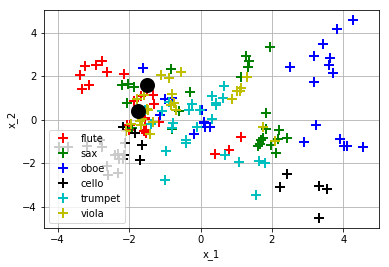

In [66]:
plot_predicted_classes(test_set, test_classes, predicted_labels, nClasses)